In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange
from utils import *

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data preprocessing

In [2]:
df = pd.read_csv('./rating_data.csv')
df_array = df.as_matrix()

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d" % (total_usr, total_item))

sparsity of ratings is 3.82%
num. of users: 5000, num. of items: 99


In [3]:
# from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(df_array, test_size=0.2)

rating = np.zeros((total_usr, total_item), dtype=np.float32)
for line in df_array:
    rating[line[0]-1, line[1]-1] = 1 if line[2] != 0. else 0

### Drop users' rating that less than 5

In [4]:
a = [usr_idx for usr_idx in range(rating.shape[0]) if np.count_nonzero(rating[usr_idx]) < 8]
rating = np.delete(rating, a, axis=0)
# a = [item_idx for item_idx in range(rating.shape[1]) if np.count_nonzero(rating.T[item_idx]) == 0]
# rating = np.delete(rating, a, axis=1)

n_u = rating.shape[0]
n_i = rating.shape[1]
count = 0

for line in rating:
    count += np.count_nonzero(line)
sparsity = count/(n_u*n_i)    
print ("new sparsity of ratings is %.2f%%" % (sparsity*100))
print (n_u, n_i)

new sparsity of ratings is 13.99%
447 99


### Get ranking of rating and assign costs weight

In [5]:
rank = []

for idx, item_id in enumerate(range(rating.shape[1])):
    rank.append(np.count_nonzero(rating.T[idx]))
    
rank = np.asarray(rank)
rank = rank.argsort()[::-1]

w = [1/x for x in range(1, n_i+1)]
penalty_weights = np.zeros(shape=n_i, dtype=np.float32)

for idx, item in enumerate(rank):
    penalty_weights[item] = w[idx]

## MAP@5 with various drop_rate

drop_rate = [0., 0.2, 0.4, 0.6, 0.8]
mAP = []

for rate in drop_rate:
    tf.reset_default_graph()
    sess = tf.Session()
    X = tf.placeholder(tf.float32, shape=(1, n_i))
    Y = tf.placeholder(tf.float32, shape=(1, n_i))

    autoencoder = AutoEncoder(sess=sess, inputs=X, user_num=n_u, hidden_units=20,
                              item_num=n_i, targets=Y, lr=0.01, epochs=50, dropout_rate=rate, 
                              cost_function='log_loss')
    autoencoder.train(rating=rating)
    ap = autoencoder.averagePrecision(rating)
    mAP.append(sum(ap)/len(ap))

plt.bar(drop_rate, mAP, width=0.1, label='MAP')
plt.legend(loc='upper left')
plt.xticks(drop_rate)
plt.xlabel('drop_rate')
plt.ylabel('mAP')
plt.show()

## Build Model and Training

In [18]:
train_rating, train_indices, test_indices = gen_train_test(rating)

tf.reset_default_graph()

autoencoder = AutoEncoder(user_num=n_u, item_num=n_i, mode='user', loss_function='log_loss',
                          epochs=1000)
# autoencoder.train(rating=train_rating,
#                   train_indices=train_indices,
#                   test_indices=test_indices,
#                   penalty_weights=penalty_weights)

In [19]:
autoencoder.train(rating=train_rating,
                  train_indices=train_indices,
                  test_indices=test_indices)

100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


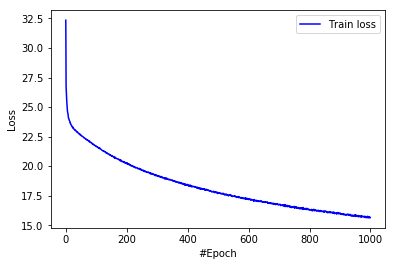

In [20]:
train_loss = autoencoder.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

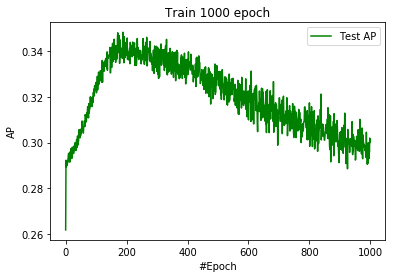

In [21]:
test_ap = autoencoder.log['ap@5']

plt.plot(range(len(test_ap)), test_ap, color='green', label='Test AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 1000 epoch")
plt.xlabel('#Epoch')
plt.ylabel('AP')
plt.show()

test_ap = autoencoder.log['ap@5']

plt.plot(range(len(test_ap)), test_ap, color='green', label='Test AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('AP')
plt.show()

## MAP@5

In [11]:
aps = []

for usr in range(rating.shape[0]):
    recon = autoencoder.decode.eval(
        session=autoencoder.sess,
        feed_dict={
            autoencoder.input: [train_rating[usr]],
            autoencoder.ident: usr
        })
    
    top5 = get_topN(recon, train_indices[usr])
    
    aps.append(avg_precision(top5, test_indices[usr]))

print ("MAP: %f" % (sum(aps)/len(aps)))

MAP: 0.039426


## MAP@5 Top10 and HitRatio

In [12]:
pop_top10 = rank[:10]
pop_top20 = rank[:20]
pop10_aps = []
hit_rates_10 = []
pop20_aps = []
hit_rates_20 = []

def hit_ratio(topN, indices):
    N = len(topN)
    hit_count = 0
    
    for i in range(N):
        hit_count += 1 if topN[i] in indices else 0
    
    try:
        return hit_count / min(N, len(indices))
    except ZeroDivisionError:
        return 100

for usr in range(rating.shape[0]):
    recon = autoencoder.decode.eval(
        session=autoencoder.sess,
        feed_dict={
            autoencoder.input: [train_rating[usr]],
            autoencoder.ident: usr
        })
    
    top5 = get_topN(recon, train_indices[usr])
    
    pop10_top5 = [x for x in top5 if x in pop_top10]
    pop10_test_index = [x for x in test_indices[usr] if x in pop_top10]
    
    pop20_top5 = [x for x in top5 if x in pop_top20]
    pop20_test_index = [x for x in test_indices[usr] if x in pop_top20]
    
    rate_10 = hit_ratio(pop10_top5, pop10_test_index)
    ap_10 = avg_precision(pop10_top5, pop10_test_index)
    
    rate_20 = hit_ratio(pop20_top5, pop20_test_index)
    ap_20 = avg_precision(pop20_top5, pop20_test_index)
    
    if ap_10 <= 1:
        pop10_aps.append(ap_10)
        hit_rates_10.append(rate_10)
        
    if ap_20 <= 1:
        pop20_aps.append(ap_20)
        hit_rates_20.append(rate_20)


print ("MAP in Popular Top 10: {0:.3f}%".format(sum(pop10_aps)/len(pop10_aps)*100))
print ("HIT_RATE in Popular Top 10: {0:.3f}%".format(sum(hit_rates_10)/len(hit_rates_10)*100))
print ()
print ("MAP in Popular Top 20: {0:.3f}%".format(sum(pop20_aps)/len(pop20_aps)*100))
print ("HIT_RATE in Popular Top 20: {0:.3f}%".format(sum(hit_rates_20)/len(hit_rates_20)*100))


MAP in Popular Top 10: 42.368%
HIT_RATE in Popular Top 10: 42.991%

MAP in Popular Top 20: 39.327%
HIT_RATE in Popular Top 20: 39.971%
